In [1]:
import tensorflow as tf
import keras
from keras.layers import Softmax,Input,TimeDistributed,Dense,Average,GlobalAveragePooling1D,Concatenate,Lambda,RepeatVector
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.utils import plot_model
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pylab as pl
from IPython import display
from IPython.core.display import HTML
from IPython.core.display import display as html_width
import tensorflow_probability as tfp
from scipy.interpolate import UnivariateSpline

html_width(HTML("<style>.container { width:90% !important; }</style>"))

/home/tuluhan/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tuluhan/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tuluhan/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tuluhan/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:5

The code base is taken from https://github.com/rssCNMP/CNMP. 

## Generating example demonstration:
These demonstrations are used in the first experiment of the <b>Reward Conditioned Neural Movement Primitives for Population Based Variational Policy Optimization</b>

This experiment does not involve reward conditioning.

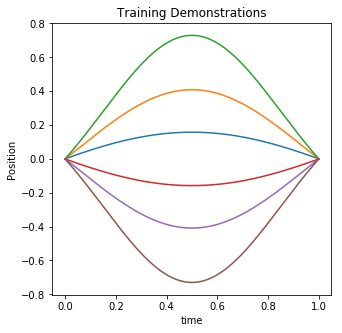

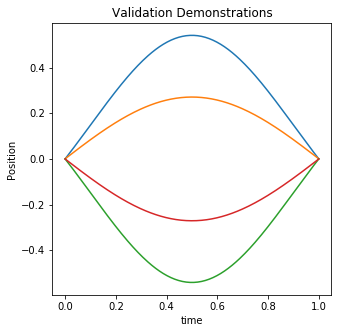

training X  (6, 200, 1)
training Y  (6, 200, 1)
validation X  (4, 200, 1)
validation Y  (4, 200, 1)


In [2]:
def dist_generator(d, x, param, noise = 0):
    f = (math.exp(-x**2/(2.*param[0]**2))/(math.sqrt(2*math.pi)*param[0]))+param[1]
    return f+(noise*(np.random.rand()-0.5)/100.)

def generate_demonstrations(time_len = 200, params = None, title = None):
    fig = plt.figure(figsize=(5,5))
    x = np.linspace(-0.5,0.5,time_len)
    times = np.zeros((params.shape[0],time_len,1))
    times[:] = x.reshape((1,time_len,1))+0.5
    values = np.zeros((params.shape[0],time_len,1))
    for d in range(params.shape[0]):
            for i in range(time_len):
                values[d,i] = dist_generator(d,x[i],params[d])
            plt.plot(times[d], values[d])
    plt.title(title+' Demonstrations')
    plt.ylabel('Position')
    plt.xlabel('time')
    plt.show()
    return times, values

X, Y = generate_demonstrations(time_len=200, params=np.array([[0.65,-0.456],[0.45,-0.478],[0.35,-0.4102],[-0.65,0.456],[-0.45,0.478],[-0.35,0.4102]]), title='Training')
v_X, v_Y = generate_demonstrations(time_len=200, params=np.array([[0.4,-0.4566],[0.53,-0.482],[-0.4,0.4566],[-0.53,0.482]]), title='Validation')
print ('training X ', X.shape)
print ('training Y ',Y.shape)
print ('validation X ', v_X.shape)
print ('validation Y ',v_Y.shape)
np.save('training_X',X)
np.save('training_Y',Y)
np.save('validation_X',v_X)
np.save('validation_Y',v_Y)

In [3]:
time_len = time_N = 200
times = np.linspace(0,1,time_len)
data_size = 6
val_size = 4

X = np.zeros((data_size,time_N,1))

for i in range(data_size):
    for j in range(time_N):
        X[i,j,0]=times[j]
        
v_X = np.zeros((val_size,time_N,1))

for i in range(val_size):
    for j in range(time_N):
        v_X[i,j,0]=times[j]
        
test_X = np.zeros((1,time_N,1))
for i in range(1):
    for j in range(time_N):
        test_X[i,j,0]=times[j]
        

## Loading model inputs
<b>Input Requirements</b>:

* <b>obs_max</b>: Hyperparameter that decides to the maximum number of observations NMP uses. In this experiment, it is set to 5
* <b>d_N</b>: Number of demonstrations

* <b>d_x</b>: X vector feature dim (NOTE THAT: external parameters are assumed to be inside of the X vector, concatenated to time value. This experiment does not use external parameters so d_x = 1)

* <b>d_y</b>: Y vector feature dim

* <b>time_len</b>: length of the demonstrations, if all demonstrations does not have same length, use array and edit methods using time_len, or preprocess your data to interpolate into same time length (check numpy.interp)

* <b>X</b>: shape=(d_N,time_len,d_x) --- time (and external parameter) values for each timestep for ith demonstration. d_x = 1+d_external_parameters

* <b>Y</b>: shape=(d_N,time_len,d_y) --- corresponding values of f(X) for ith demonstration

* <b>obs_mlp_layers</b>: Hidden neuron numbers of the dense layers inside of the Observation multi layer perceptron. Layer numbers can adapt to the list size. Last layer is always Linear, others are ReLU activated.

* <b>decoder_layers</b>: Hidden neuron numbers of the dense layers inside of the Decoder multi layer perceptron. Layer numbers can adapt to the list size. Last layer size is always 2*d_y and activation is Linear, others are ReLU activated.

In [4]:
obs_max = 5 
d_N = X.shape[0] 
d_x , d_y = (X.shape[-1] , Y.shape[-1])
time_len = X.shape[1]
obs_mlp_layers = [128,64,32,16,8,4]
decoder_layers = [128,128,d_y]

print ('d_N=', d_N)
print ('obs_max=', obs_max)
print ('X',X.shape,', Y',Y.shape)
print ('d_x=',d_x)
print ('d_y=',d_y)
print ('time_len=', time_len )

d_N= 6
obs_max= 5
X (6, 200, 1) , Y (6, 200, 1)
d_x= 1
d_y= 1
time_len= 200


# Neural Movement Primitives

### <b>get_train_sample()</b>: 
* Selects a random observation number, n
* Selects a random demonstration id, d
* Permutes demonstration d, so the first n data can be observation. Selects (n+1)th data to be the target point
* Returns observations and target_X as inputs to the model to predict target_Y

In [5]:
def get_train_sample():
    n = np.random.randint(0,obs_max)+1
    d = np.random.randint(0, d_N)
    observation = np.zeros((1,n,d_x+d_y)) 
    target_X = np.zeros((1,1,d_x))
    target_Y = np.zeros((1,1,d_y))
    perm = np.random.permutation(time_len)
    observation[0,:n,:d_x] = X[d,perm[:n]]
    observation[0,:n,d_x:d_x+d_y] = Y[d,perm[:n]]
    target_X[0,0] = X[d,perm[n]]
    target_Y[0,0,:d_y] = Y[d,perm[n]]
    return [observation,target_X], target_Y

### <b>predict_model()</b>: 
* Predicts whole trajectory according to the given observation batch
* <b>observation</b>: observation points as a batch. 
  * Dimension must be -> (1, obs_n, d_x+d_y) where obs_n is the number of observations for this prediction
* <b>target_X</b>: target X points as a batch. Model can predict one, multi, partial or whole trajectory/points as long as input is shaped as a batch
  * Dimension must be -> (1, target_n, d_x) where target_n is the number of points to predict
  * For whole trajectory give all X points through time length as a batch (for ex. the first demonstration = X[0].reshape=(1,time_len,d_x) 
* <b>prediction</b>: Output that holds predicted means and standart deviations for each time point in the X. Later splitted into <b>predicted_Y</b> and <b>predicted_std</b>
* <b>plot</b>: if True, plots demonstrations and predicted distribution
* Returns predicted means and stds

In [6]:
def predict_model(observation, target_X, plot = True):
    predicted_Y = np.zeros((time_len,d_y))
    predicted_std = np.zeros((time_len,d_y))
    prediction = model.predict([observation,target_X])[0][0]
    predicted_Y = prediction[:,:d_y]
    if plot: # We highly recommend that you customize your own plot function, but you can use this function as default
        for i in range(d_y): #for every feature in Y vector we are plotting training data and its prediction
            fig = plt.figure(figsize=(5,5))
            for j in range(d_N):
                plt.plot(X[j,:,0],Y[j,:,i]) # assuming X[j,:,0] is time
            plt.plot(X[j,:,0],predicted_Y[:,i],color='black')
            plt.show()  
    return predicted_Y, predicted_std

### Z Sampling():
* Samples z according to given mean and log variance

In [7]:
def z_sampling(args):
    z_m, z_l_v = args
    batch = K.shape(z_m)[0]
    dim = K.int_shape(z_m)[-1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = 2*K.random_normal(shape=(batch, dim))
    return z_m + K.exp(0.5 * z_l_v) * epsilon

def s_sampling(args):
    d_m, d_l_v = args
    batch = K.shape(d_m)[0]
    dim = K.int_shape(d_m)[-1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    epsilon = K.repeat(epsilon,K.shape(d_m)[1])
    return d_m + K.exp(0.5 * d_l_v) * epsilon

### MLP():

* Constructs a multilayer perceptron according to the given input dimension and layer sizes.
* <b>input_dim</b>: dimension of the input feature vector
* <b>layers</b>: Constructs a dense layer for each number in the list. Layer numbers are flexible to list size. Except for the last layer, all layers are ReLU activated.
  * ex: (2,[128,128,128]) Constructs a multi layer perceptron with each dense layer's neuron sizes correspond to (2->128->128->128) from input to output
  * ex: (4,[128,4]) Constructs a multi layer perceptron with each dense layer's neuron sizes correspond to (4->128->4) from input to output
* <b>parallel_input</b>:
  * if <b>False</b>, MLP acts as classical fully connected MLP. Output is a single result.
  * if <b>True</b>, MLP acts as a single parameter-sharing network. Every tuple in the input batch passes through MLP paralelly, independently from each other. Output is a batch which every row is the result of the corresponding tuple from the input batch passing through the parameter-sharing network.
  * <b>TLDR;</b> use parallel input for encoding observations into representations, and fully connected MLP for every any other dense networks.

In [8]:
def MLP(input_dim, layers, name="mlp", parallel_inputs=False):
    input_layer = Input(shape=(None, input_dim),name=name+'_input')
    for i in range(len(layers)-1):
        hidden = TimeDistributed(Dense(layers[i], activation='relu'), name=name+'_'+str(i))(input_layer if i == 0 else hidden) if parallel_inputs else Dense(layers[i], activation='relu', name=name+'_'+str(i))(input_layer if i == 0 else hidden)
    hidden = TimeDistributed(Dense(layers[-1]), name=name+'_output')(hidden) if parallel_inputs else Dense(layers[-1], name=name+'_output')(hidden)
    return Model(input_layer, hidden, name=name)

## NMP model:

In [9]:
observation_layer = Input(shape=(None,d_x+d_y), name="observation") # (x_o,y_o) tuples
target_X_layer = Input(shape=(None,d_x), name="target") # x_q
print(np.shape(observation_layer))
print(np.shape(target_X_layer))

ObsMLP = MLP(d_x+d_y, obs_mlp_layers, name='obs_mlp', parallel_inputs=True) # Network E
obs_representations = ObsMLP(observation_layer) # r_i
general_representation1 = GlobalAveragePooling1D()(obs_representations) # r

z_mean = Dense(4,name='z_mean')(general_representation1) # Z mean
z_log_var = Dense(4,name='z_log_var')(general_representation1) # Z log var
z_log_var2 = Lambda(lambda x: 0.001+tf.nn.softplus(x))(z_log_var)
z = Lambda(z_sampling, output_shape=(4,), name='z')([z_mean, z_log_var]) # Z Sample
z = Lambda(lambda x: tf.keras.backend.repeat(x[0],tf.shape(x[1])[1]), name='Repeat_z')([z,target_X_layer]) # z in batch form (same)


merged_layer = Concatenate(axis=2, name='merged')([z,target_X_layer]) # (r,x_q) tuple
Decoder = MLP(d_x+obs_mlp_layers[-1], decoder_layers, name = 'decoder_mlp', parallel_inputs=False) # Network Q
output = Decoder(merged_layer) # (mean_q, std_q)

vae_loss = 0.01 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1. - z_log_var, axis=1)

model = Model([observation_layer, target_X_layer],[output,z_log_var])
model_z = Model([observation_layer],z_mean)
model_z_var = Model([observation_layer],z_log_var)
model_z_var2 = Model([observation_layer],z_log_var2)

model.add_loss(vae_loss)
model.compile(optimizer = Adam(lr = 1e-4), loss={'decoder_mlp': 'mse'})
model.summary()

rep_model = Model([observation_layer],general_representation1)



W1119 15:34:27.566462 139794749376256 deprecation_wrapper.py:119] From /home/tuluhan/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1119 15:34:27.581405 139794749376256 deprecation_wrapper.py:119] From /home/tuluhan/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1119 15:34:27.582213 139794749376256 deprecation_wrapper.py:119] From /home/tuluhan/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



(?, ?, 2)
(?, ?, 1)


W1119 15:34:27.881094 139794749376256 deprecation_wrapper.py:119] From /home/tuluhan/.local/lib/python3.5/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation (InputLayer)        (None, None, 2)      0                                            
__________________________________________________________________________________________________
obs_mlp (Model)                 (None, None, 4)      11420       observation[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 4)            0           obs_mlp[1][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 4)            20          global_average_pooling1d_1[0][0] 
__________________________________________________________________________________________________
z_log_var 

/home/tuluhan/.local/lib/python3.5/site-packages/ipykernel_launcher.py:29: UserWarning: Output "z_log_var" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "z_log_var" during training.


### generator():

* Generates data using get_train_sample function during training

In [10]:
def generator():
    while True:
        inp,out = get_train_sample()
        yield (inp, out)

### NMP_Callback:

* NMP_Callback is a customizable class that manages the NMP training process.
* <b>on_train_begin()</b>: Initializes the training process
  * <b>step</b>: training step counter  
  * <b>losses</b>: holds the training losses for every loss_checkpoint   
  * <b>smooth_losses</b>: holds the means of losses[] for every plot_checkpoint 
  * <b>loss_checkpoint</b>: hyperparameter for loss recording
  * <b>plot_checkpoint</b>: hyperparameter for loss smoothing and on-train example plotting
  * <b>validation_checkpoint</b>: hyperparameter for validation checking to record best model
* <b>on_batch_end()</b>: 
  * End of every training iteration, step counter increases
  * Customized checkpoints are handled if step counter gets to the corresponding checkpoint
  
  

In [11]:
class NMP_Callback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.smooth_losses = [0]
        self.losses = []
        self.step = 0
        self.loss_checkpoint = 1000
        self.plot_checkpoint = 5000
        self.validation_checkpoint = 100
        self.validation_error = 9999999
        return

    def on_batch_end(self, batch, logs={}):
        if self.step % self.validation_checkpoint == 0:
            ### Here, you should customize our own validation function according to your data and save your best model ###
            current_error = 0
            for i in range(v_X.shape[0]):
                # predicting whole trajectory by using the first time step of the ith validation trajectory as given observation
                predicted_Y,predicted_std = predict_model(np.concatenate((v_X[i,100],v_Y[i,100])).reshape(1,1,d_x+d_y), v_X[i].reshape(1,time_len,d_x), plot= False)
                current_error += np.mean((predicted_Y - v_Y[i,:])**2) / v_X.shape[0]
            if current_error < self.validation_error:
                self.validation_error = current_error
                model.save('nmp_best_validation_exp1.h5')
                print (' New validation best. Error is ', current_error)
            ### If you are not using validation, please note that every large-enough nn model will eventually overfit to the input data ###
            
        if self.step % self.loss_checkpoint == 0:
            self.losses.append(logs.get('loss'))
            self.smooth_losses[-1] += logs.get('loss')/(self.plot_checkpoint/self.loss_checkpoint)
            
        if self.step % self.plot_checkpoint == 0:
            print (self.step)
            #clearing output cell
            display.clear_output(wait=True)
            display.display(pl.gcf())
            
            for i in range(1):
                #for each validation trajectory, predicting and plotting whole trajectories by using the first time steps as given observations. 
                predict_model(np.concatenate((test_X[i,100],v_Y[i,100])).reshape(1,1,d_x+d_y), test_X[i].reshape(1,time_len,d_x))
            
            if self.step!=0:
                self.smooth_losses.append(0)
            
        self.step += 1
        return

### Starting the training

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

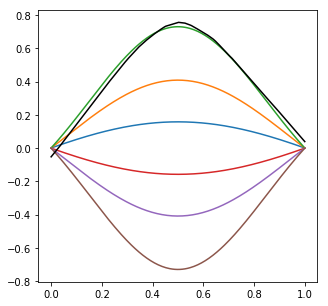

 233057/1000000 [=====>........................] - ETA: 20:22 - loss: 0.0582 - decoder_mlp_loss: 0.0250

KeyboardInterrupt: 

In [12]:
max_training_step = 1000000
model.fit_generator(generator(), steps_per_epoch=max_training_step, epochs=1, verbose=1, callbacks=[NMP_Callback()])

In [ ]:
model.load_weights('nmp_best_validation_exp1.h5')
a,b=predict_model(np.concatenate(([0.],[0.5])).reshape(1,1,d_x+d_y), test_X[0].reshape(1,time_len,d_x))

### Testing the Model

In [13]:
def plot_func2(Y,Y2):
    fig = plt.figure(figsize=(5,5))
    for i in range(len(Y)):
        plt.plot(times,Y[i,:,0])
    for i in range(len(Y2)):
        plt.plot(times,Y2[i,:,0],'gray')
    #plt.scatter(0.5,-0.65,c = 'black', s=400)
    plt.grid(True)
    plt.title('Sampled Trajectories')
    
    plt.xlabel('time')
    plt.savefig('experiment_1_soln.png',bbox_inches='tight')
    plt.show()

In [22]:
def PD(initial=1,final=-5.2879958,fss = np.zeros((time_N)) ):
    pos=np.zeros((time_N))
    vel=np.zeros((time_N))
    err=np.zeros((time_N))
    err_derivative=np.zeros((time_N))
    errsum = 0
    time = np.linspace(0,10,time_N)
    pos[0]=initial
    err[0]=fss[0]-pos[0]
    err_derivative[0] = 0
    for i in range(1,time_N):
        vel[i]= 3*err[i-1] - 1*err_derivative[i-1] 
        pos[i]=(time[i]-time[i-1])*vel[i]+pos[i-1]
        err[i]=(1-times[i]**20)*(fss[i]-pos[i])+(times[i]**20)*3*(final-pos[i])
        err_derivative[i] = err[i]-err[i-1]
    return pos

[0.]


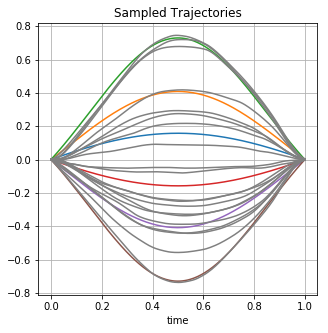

In [29]:
observation = np.zeros((1,1,d_x+d_y)) 
print(test_X[0,0])
observation[0,0,:d_x] = 0
observation[0,0,d_x:d_x+d_y] = 0
target_X = test_X[0].reshape(1,time_len,d_x)

mean_rep = np.zeros((4))
var_rep =  np.ones((4))
cov_matrix = np.diag(var_rep)


Y_result = np.zeros((20,time_N,2))
for i in range(20):
    temp_reps = np.random.multivariate_normal(mean_rep, cov_matrix, 1)
    temp_reps = np.reshape(temp_reps,(1,1,4))         #predicted_traj using reps
    temp_reps = np.repeat(temp_reps,200,axis=1)
    decoder_in = np.concatenate((temp_reps,target_X),axis = 2)
    prediction = Decoder.predict(decoder_in)
    prediction[0,:,0] = PD(0,0,prediction[0,:,0])
    Y_result[i]=prediction

plot_func2(Y,Y_result) 